# Transfer Learning with EfficientNet on Custom Food Dataset

This notebook demonstrates how to apply transfer learning using PyTorch's pretrained models to classify images of food (Pizza, Steak, Sushi). We use a pretrained EfficientNet-B0 model and fine-tune it on a small subset of the Food101 dataset.

Key objectives:
- Use `torchvision.models` to load and modify a pretrained model
- Apply appropriate input transforms
- Fine-tune the model on a small dataset


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular.going_modular import data_setup, engine

device = "mps" if torch.mps.is_available() else "cpu"
# device = "cpu"
print(device)

import os
import zipfile

from pathlib import Path
import requests

from timeit import default_timer as timer

mps


## Dataset

The dataset is the same Pizza/Steak/Sushi subset used in the previous notebook. It is structured for use with `torchvision.datasets.ImageFolder`, with images stored in train/test directories.


In [2]:
#we will work with the modular files we have created previously in the custom datasets notebook
#these are python files (modular)

#check data exists #same pizza/sushi/steak dataset

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

print(image_path.is_dir())

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir


True


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Image Transformations for Transfer Learning

Pretrained models expect inputs of a specific size and normalization, based on the dataset they were originally trained on (e.g., ImageNet).

- Manual transforms resize to `(224x224)`, normalize using ImageNet stats
- Auto transforms can be pulled directly from the model weights via `weights.transforms()`

Both methods ensure input compatibility with EfficientNet-B0.


In [3]:
#now we will take our data and transform to our needs 
#to be used with torchvision.models - where we get the pretrained model from

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #these values come from docs
                         std=[0.229,0.224,0.225])
])

#An alternate way is to use auto_transforms

#identify pretrained model and grab weights:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #best available are default
# weights

auto_transforms = weights.transforms()
auto_transforms #gives same thing as out manual_transforms thing, and can be used with the dataloaders

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [4]:
#now create dataloaders using data_setup.py file
#we can use either manual_transforms or auto_transforms here, same thing
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1053a7400>,
 ['pizza', 'steak', 'sushi'])

## Model: EfficientNet-B0

Pretrained `EfficientNet_B0` model from `torchvision.models`. Key points:

- Weights are loaded using `EfficientNet_B0_Weights.DEFAULT`
- The model is modified to output 3 classes instead of 1000 (from ImageNet)
- The final classification head is replaced and made trainable

Model summary:
- Input: (3, 224, 224)
- Output: (batch_size, 3)


In [5]:
##GET A PRETRAINED MODEL
#resnet, vgg, efficientnet, visiontransformers(ViT), ConvNeXt all from torchvision.models

#we will be using torchvision.models.efficientnet_b0()

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [6]:
#now we freeze the base model and then change the output layer to suit our needs
#3 classes to classify vs the 1000 classes the model can classify

for param in model.features.parameters():
    param.requires_grad = False


#notice how the last Sequential block is called "classifier", we can update this
#with our own

torch.manual_seed(42)
torch.mps.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)


#print summary again to see what changed
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [7]:
#train the model

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
#now use engine.py to grab train() 
# trains and tests the model and saves results

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()

print(f"Total training time = {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/saksh/miniforge3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0341 | train_acc: 0.5234 | test_loss: 0.8836 | test_acc: 0.5805
Epoch: 2 | train_loss: 0.9139 | train_acc: 0.6211 | test_loss: 0.7294 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.7617 | train_acc: 0.8672 | test_loss: 0.6990 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7048 | train_acc: 0.7539 | test_loss: 0.5882 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6225 | train_acc: 0.7891 | test_loss: 0.5896 | test_acc: 0.8759
Total training time = 307.159 seconds


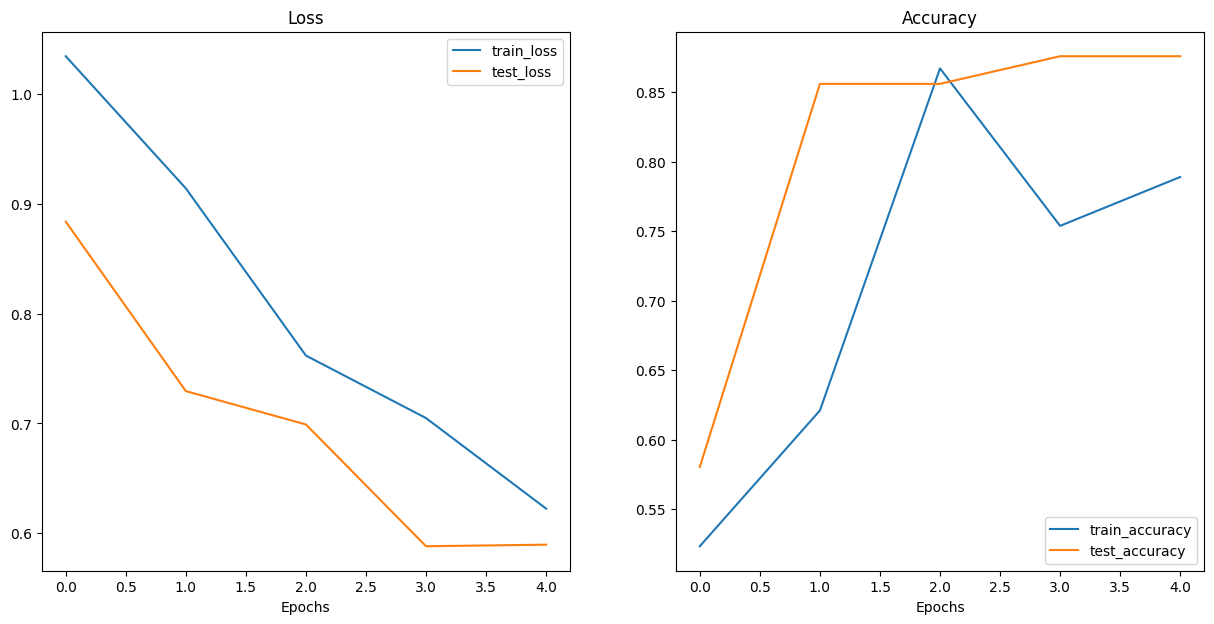

In [9]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)


## Conclusion

This notebook demonstrates how to apply transfer learning to a custom image classification problem using PyTorch. EfficientNet-B0 was adapted to a new task with minimal training data, showcasing:

- Reusability of pretrained models
- Importance of proper transforms
- Power of transfer learning for small-scale tasks

This is a valuable technique for practical ML work with limited labeled data.
